<a href="https://colab.research.google.com/github/Sereniiti/ai-models/blob/main/New_data_Ngrams_Sentiment_analysis_model_binary_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard 
import os, datetime 

In [4]:
nltk.download ("stopwords")

import matplotlib.pyplot as plt
!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dff = pd.read_csv('/content/drive/MyDrive/sereniiti-dataset-0.0.2.csv')
dff.head ()

,Unnamed: 0,id,en,fr,rating,tips,tips_groups,steps,fivefold,step_facts,step_emotions,step_needs,step_proposals,tip_morality,tip_positivebias,tip_interpretation,tip_comparison,tip_labelling,tip_generalisation,tip_duality,tip_reproach,tip_deserves,tip_denial,tip_sacrifice,tip_unavailable,tip_unsolicited,tip_provocation,tip_fact,tip_selfempathy,tip_empathy,tip_dialogue,tip_clarity,tip_activity,tip_demand,tip_person,tip_who,tip_location,tip_where,tip_time,tip_when,tip_action,tip_what,tip_objective,tip_why,tip_thismany,tip_howmany,tip_positive,tip_negative,tip_realistic,tip_unrealistic,tip_feeling,tip_need,group_empathy,group_negative,group_feeling,group_fault,group_unsolicited,group_need,group_realistic,group_precise,group_unprecise,group_unrealistic,group_provocation,group_positivebias,group_judgemental,group_demanding,group_fact,group_positive
0,1,1,"60,000 sperms, and you won?","60 000 spermatozoïdes, et tu as gagné ?",0,"comparison,provocation","provocation,judgemental",facts,3.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,2,2,A 2014 study examined the effects of combined ...,Une étude de 2014 a examiné les effets d'une f...,4,fact,fact,facts,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,3,A big guy like you needs to stand up for himself!,Un grand gars comme toi doit savoir se défendre!,1,"labelling,reproach","judgemental,fault",facts,4.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,4,4,"A cheetah, the fastest land animal, can run 70...","Un guépard, l'animal terrestre le plus rapide,...",4,fact,fact,facts,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5,5,A combination of words that makes sense is cal...,Une combinaison de mots qui a un sens complet ...,4,fact,fact,facts,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [7]:
dfp=dff [['en', 'rating', 'fivefold']]
dfp

,en,rating,fivefold
0,"60,000 sperms, and you won?",0,3.0
1,A 2014 study examined the effects of combined ...,4,5.0
2,A big guy like you needs to stand up for himself!,1,4.0
3,"A cheetah, the fastest land animal, can run 70...",4,2.0
4,A combination of words that makes sense is cal...,4,2.0
...,...,...,...
11296,Some of the people who come to us for food are...,5,1.0
11297,Would you mind telling me how you feel when yo...,5,2.0
11298,I feel frustrated,4,3.0
11299,"Each time, you take the day before to start re...",1,4.0


In [8]:
dfp

,en,rating,fivefold
0,"60,000 sperms, and you won?",0,3.0
1,A 2014 study examined the effects of combined ...,4,5.0
2,A big guy like you needs to stand up for himself!,1,4.0
3,"A cheetah, the fastest land animal, can run 70...",4,2.0
4,A combination of words that makes sense is cal...,4,2.0
...,...,...,...
11296,Some of the people who come to us for food are...,5,1.0
11297,Would you mind telling me how you feel when yo...,5,2.0
11298,I feel frustrated,4,3.0
11299,"Each time, you take the day before to start re...",1,4.0


In [9]:
dfp ['Violence_Rating']=dfp ['rating'].apply(lambda x: 0 if x >= 3 else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


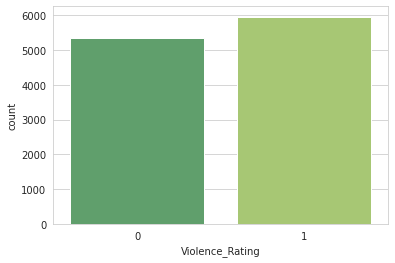

In [10]:
sns.set_style ('whitegrid')
sns.countplot (x='Violence_Rating', data=dfp, palette='summer')

In [11]:
def get_text_processing(text):
    stpword = ['the','a', 'an']
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [12]:
dfp['en_processed'] = dfp['en'].apply(get_text_processing)
dfp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,en,rating,fivefold,Violence_Rating,en_processed
0,"60,000 sperms, and you won?",0,3.0,1,60000 sperms and you won
1,A 2014 study examined the effects of combined ...,4,5.0,0,2014 study examined effects of combined NVC an...
2,A big guy like you needs to stand up for himself!,1,4.0,1,big guy like you needs to stand up for himself
3,"A cheetah, the fastest land animal, can run 70...",4,2.0,0,cheetah fastest land animal can run 70 miles hour
4,A combination of words that makes sense is cal...,4,2.0,0,combination of words that makes sense is calle...


In [13]:
dfp = dfp[['en_processed', 'Violence_Rating', 'fivefold']]
dfp.head()

,en_processed,Violence_Rating,fivefold
0,60000 sperms and you won,1,3.0
1,2014 study examined effects of combined NVC an...,0,5.0
2,big guy like you needs to stand up for himself,1,4.0
3,cheetah fastest land animal can run 70 miles hour,0,2.0
4,combination of words that makes sense is calle...,0,2.0


In [14]:
grouped = dfp.groupby(dfp.fivefold)
dfv = grouped.get_group(5.0)
dfv=dfv.drop(['fivefold'],axis=1)
dfv.dropna(inplace=True)
dfv

,en_processed,Violence_Rating
1,2014 study examined effects of combined NVC an...,0
21,According to this article volcanoes in Auvergn...,0
24,Act like youre shocked Mr Puritan,1
35,From experienced editor its just shameful,1
40,After this dance Im full of energy,0
...,...,...
11280,SpongeBob is pile of crap now,1
11285,Super nice your subliminal messages,1
11290,Why would you think that,0
11295,I was worried,0


In [15]:
dfm = dfp.set_index("fivefold")
dfm= dfm.drop (5.0)
dfm

,en_processed,Violence_Rating
fivefold,,
3.0,60000 sperms and you won,1
4.0,big guy like you needs to stand up for himself,1
2.0,cheetah fastest land animal can run 70 miles hour,0
2.0,combination of words that makes sense is calle...,0
3.0,door would have more charisma than you,1
...,...,...
4.0,I will call authorities if these actions continue,1
1.0,Some of people who come to us for food are tee...,0
2.0,Would you mind telling me how you feel when yo...,0


In [16]:
dfm.reset_index(drop=True, inplace=True)
dft = dfm
dft

,en_processed,Violence_Rating
0,60000 sperms and you won,1
1,big guy like you needs to stand up for himself,1
2,cheetah fastest land animal can run 70 miles hour,0
3,combination of words that makes sense is calle...,0
4,door would have more charisma than you,1
...,...,...
9119,I will call authorities if these actions continue,1
9120,Some of people who come to us for food are tee...,0
9121,Would you mind telling me how you feel when yo...,0
9122,I feel frustrated,0


In [31]:
X1 = dft["en_processed"].values
X2= dfv["en_processed"].values
X3= dfv["en_processed"].values
Y1= dft.drop("en_processed", axis=1).values
Y2= dfv.drop("en_processed", axis=1).values
X1_train, X1_test, Y1_train, Y1_test=train_test_split(X1,Y1, test_size=0.30, random_state=42)


In [32]:
dfffff = pd.DataFrame (X1)
dfffff

,0
0,60000 sperms and you won
1,big guy like you needs to stand up for himself
2,cheetah fastest land animal can run 70 miles hour
3,combination of words that makes sense is calle...
4,door would have more charisma than you
...,...
9119,I will call authorities if these actions continue
9120,Some of people who come to us for food are tee...
9121,Would you mind telling me how you feel when yo...
9122,I feel frustrated


In [33]:
vect = CountVectorizer(analyzer='word', ngram_range=(1, 5))
X1_train = vect.fit_transform (X1_train)
X1_test = vect.transform(X1_test)
X2= vect.transform(X2)


In [ ]:
tfidf = TfidfTransformer()
X1_train = tfidf.fit_transform(X1_train)
X1_test = tfidf.transform(X1_test)
X1_train = X1_train.toarray()
X1_test = X1_test.toarray()
X2= tfidf.fit_transform (X2)
X2= X2.toarray ()

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense (units = 20, kernel_initializer= 'uniform', activation= 'relu'))
model.add(tf.keras.layers.Dense (units = 20, kernel_initializer= 'uniform', activation= 'relu'))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
model.compile (optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5) #which quantity to monitor to decide early stopping 

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

callbacks = [early_stopping, ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True), 
TensorBoard(logdir, histogram_freq=1)] 

history = model.fit( 
X1_train, 
Y1_train, 
epochs=200, 
validation_split=0.25, 
batch_size=40, 
verbose=2, 
callbacks=[callbacks] 
)

Epoch 1/200
120/120 - 2s - loss: 0.6818 - accuracy: 0.5471 - val_loss: 0.6294 - val_accuracy: 0.6781 - 2s/epoch - 20ms/step
Epoch 2/200
120/120 - 2s - loss: 0.4264 - accuracy: 0.8682 - val_loss: 0.3346 - val_accuracy: 0.8723 - 2s/epoch - 13ms/step
Epoch 3/200
120/120 - 2s - loss: 0.1345 - accuracy: 0.9678 - val_loss: 0.2849 - val_accuracy: 0.8804 - 2s/epoch - 14ms/step
Epoch 4/200
120/120 - 2s - loss: 0.0502 - accuracy: 0.9910 - val_loss: 0.2734 - val_accuracy: 0.8885 - 2s/epoch - 14ms/step
Epoch 5/200
120/120 - 2s - loss: 0.0226 - accuracy: 0.9967 - val_loss: 0.2776 - val_accuracy: 0.8904 - 2s/epoch - 13ms/step
Epoch 6/200
120/120 - 2s - loss: 0.0123 - accuracy: 0.9985 - val_loss: 0.2845 - val_accuracy: 0.8917 - 2s/epoch - 14ms/step
Epoch 7/200
120/120 - 1s - loss: 0.0078 - accuracy: 0.9992 - val_loss: 0.2913 - val_accuracy: 0.8910 - 1s/epoch - 12ms/step
Epoch 8/200
120/120 - 1s - loss: 0.0056 - accuracy: 0.9996 - val_loss: 0.2970 - val_accuracy: 0.8910 - 1s/epoch - 12ms/step
Epoch 9/

In [30]:
from keras.models import load_model 
saved_model = load_model('best_model.h5') 
test_acc = saved_model.evaluate(X1_test, Y1_test)

86/86 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.9032


In [24]:
predss = saved_model.predict (X2)
predss


array([[0.00774944],
       [0.29074347],
       [0.9991821 ],
       ...,
       [0.7721828 ],
       [0.00665858],
       [0.9777711 ]], dtype=float32)

In [25]:


DFN = np.c_[X3, Y2, predss]

dfz = pd.DataFrame (DFN)
dfz

,0,1,2
0,2014 study examined effects of combined NVC an...,0,0.00774944
1,According to this article volcanoes in Auvergn...,0,0.290743
2,Act like youre shocked Mr Puritan,1,0.999182
3,From experienced editor its just shameful,1,0.954708
4,After this dance Im full of energy,0,0.0103359
...,...,...,...
2172,SpongeBob is pile of crap now,1,0.943063
2173,Super nice your subliminal messages,1,0.860795
2174,Why would you think that,0,0.772183
2175,I was worried,0,0.00665858


In [27]:
dfz.to_csv(r'/content/drive/MyDrive/final_table17NGrams.csv', index = False)